In [1]:
# GPU Access
!nvidia-smi

Tue Aug 13 21:14:24 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# **Libraries**

In [2]:
!pip install ultralytics==8.2.68

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.68 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5771.7/8062.4 GB disk)


In [3]:
!pip install -U "ray[train]"
!pip install "ray[tune]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 23.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: ray
    Found existing installation: ray 2.9.0
    Uninstalling ray-2.9.0:
      Successfully uninstalled ray-2.9.0


In [16]:
!pip install -U ipywidgets

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 1.4 MB/s eta 0:00:00 0:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 4.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 8.8 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.7
    Uninstalling widgetsnbextension-3.6.7:
      Successfully uninstalled widgetsnbextension-3.6.7
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 3.0.9
    Uninstalling jupyterlab-widgets-3.0.9:
      Successfully uninstalled jupyterlab-widgets-3.0.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [4]:
from ultralytics import YOLO
import os
from IPython.display import display, Image

In [5]:
import yaml

import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import pathlib
%matplotlib inline
from collections import Counter
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# **EDA**

## Yaml File reading

In [5]:
# Define the path to your YAML file
yaml_file_path = '/kaggle/input/yaml11/kaggle_config.yaml'

# Open and read the content of the YAML file
with open(yaml_file_path, 'r') as file:
    yaml_content = file.read()

# Print the content of the YAML file
print(yaml_content)


path: /kaggle/working/  # dataset root dir
train: preprocessed_train/images  # train images (relative to 'path')
val: preprocessed_valid/images  # val images (relative to 'path')

# Classes
names:
  0: text
  1: photo
  2: flag
  3: logo

weights: [0.3360196391582005, 0.3755446995108166, 0.26491705265064025, 0.023518608680342633]


## **Image resolutions**

In [6]:
import cv2
from pathlib import Path

# Define the input directory
input_dir = '/kaggle/input/ocr-project-dataset/proxy dataset/train/images'

# Create the Path object
input_path = Path(input_dir)

# Get list of all image paths in the directory
image_paths = list(input_path.glob('*.*'))  # Adjust the glob pattern according to your image formats

# Check if image_paths is populated correctly
if not image_paths:
    print("No images found in the directory. Check the path or image extensions.")
else:
    print(f"Found {len(image_paths)} images in the directory.")

# Initialize the list to store resolutions
resolutions = []

# Iterate over each image path and get the resolution
for image_path in image_paths:
    img = cv2.imread(str(image_path))
    if img is not None:
        h, w, _ = img.shape
        resolutions.append((w, h))
    else:
        print(f"Failed to read image: {image_path}")

# Get unique resolutions
unique_resolutions = set(resolutions)
print("Unique resolutions:", unique_resolutions)


Found 4036 images in the directory.
Unique resolutions: {(640, 640)}


## **Class distribution**

DataFrame content:
        count
photo   2967
logo   47377
flag    4206
text    3316


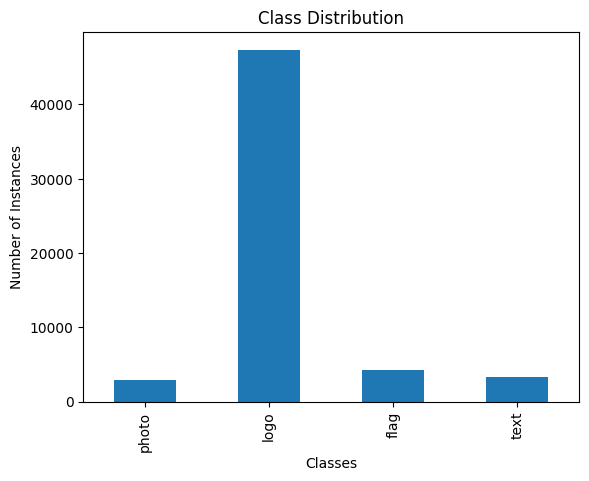

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Paths based on your YAML file
dataset_path = "/kaggle/input/ocr-project-dataset/proxy dataset"
train_labels_path = os.path.join(dataset_path, "train/labels")
val_labels_path = os.path.join(dataset_path, "valid/labels")

# Class names based on your YAML file
class_names = {0: 'text', 1: 'photo', 2: 'flag', 3: 'logo'}

# Function to count classes in label files
def count_classes(label_dir):
    class_counts = Counter()
    for label_file in os.listdir(label_dir):
        file_path = os.path.join(label_dir, label_file)
        if os.path.isfile(file_path):
            with open(file_path, "r") as file:
                lines = file.readlines()
            class_ids = [int(line.split()[0]) for line in lines if line.strip()]
            class_counts.update(Counter(class_ids))
    return class_counts

# Count classes in train and validation datasets
train_class_counts = count_classes(train_labels_path)
val_class_counts = count_classes(val_labels_path)

# Combine counts from train and validation datasets
total_class_counts = train_class_counts + val_class_counts

# Replace class IDs with class names
class_counts_names = {class_names[class_id]: count for class_id, count in total_class_counts.items()}

# Create a pandas DataFrame
df = pd.DataFrame.from_dict(class_counts_names, orient="index", columns=["count"])
df['count'] = pd.to_numeric(df['count'])

# Debugging: Print the DataFrame to verify its content
print("DataFrame content:\n", df)

# Plot the bar chart
ax = df.plot(kind="bar", legend=False)
plt.xlabel("Classes")
plt.ylabel("Number of Instances")
plt.title("Class Distribution")
plt.show()


## **Distribution of objects detected within the images**

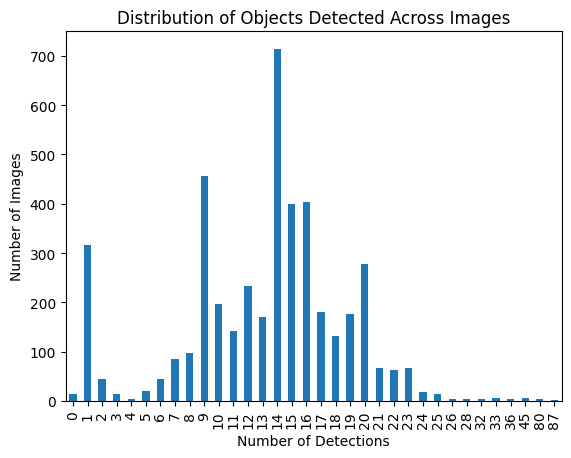

In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Paths based on your YAML file
train_labels_path = "/kaggle/input/ocr-project-dataset/proxy dataset/train/labels"
val_labels_path = "/kaggle/input/ocr-project-dataset/proxy dataset/valid/labels"

# Collect label file paths
label_paths = [os.path.join(root, file)
               for path in [train_labels_path, val_labels_path]
               for root, _, files in os.walk(path)
               for file in files if file.endswith(".txt")]

# Collect data
data = [len(open(file).readlines()) for file in label_paths]

# Create DataFrame and plot distribution
pd.Series(data).value_counts().sort_index().plot(kind='bar')
plt.xlabel('Number of Detections')
plt.ylabel('Number of Images')
plt.title('Distribution of Objects Detected Across Images')
plt.show()


# **Data Preprocessing**

## **Adjusting the weight of the majority class**

In [6]:
import numpy as np

# Define the counts for each class
class_counts = {
    'photo': 2967,
    'logo': 47377,
    'flag': 4206,
    'text': 3316
}

# Calculate class weights
total_samples = sum(class_counts.values())
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

# Normalize weights
sum_weights = sum(class_weights.values())
class_weights_normalized = {cls: weight / sum_weights for cls, weight in class_weights.items()}

print("Class Weights:")
print(class_weights_normalized)


Class Weights:
{'photo': 0.3755446995108166, 'logo': 0.023518608680342633, 'flag': 0.26491705265064025, 'text': 0.3360196391582005}


## **Testing Different image preprocessing techniques**

In [ ]:
def process_image(image):
    # Resize image
    resize_dim = (640, 640)
    resized_image = cv2.resize(image, resize_dim)
    
    # Apply Gaussian blur
    blurred_image = cv2.GaussianBlur(resized_image, (5, 5), 0)
    
    # Enhance contrast using histogram equalization
    yuv_image = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2YUV)
    y, u, v = cv2.split(yuv_image)
    eq_y = cv2.equalizeHist(y)
    contrast_enhanced_yuv = cv2.merge([eq_y, u, v])
    contrast_enhanced_image = cv2.cvtColor(contrast_enhanced_yuv, cv2.COLOR_YUV2BGR)
    
    # Sharpen image
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened_image = cv2.filter2D(contrast_enhanced_image, -1, kernel)
    
    # Normalize image to range [0, 1]
    normalized_image = sharpened_image / 255.0
    
    # Convert back to uint8
    output_image = (normalized_image * 255).astype(np.uint8)
    
    return output_image

def display_images(original_image, preprocessed_image):
    # Convert images to RGB for displaying with matplotlib
    original_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    preprocessed_rgb = cv2.cvtColor(preprocessed_image, cv2.COLOR_BGR2RGB)
    
    # Display images
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_rgb)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title("Preprocessed Image")
    plt.imshow(preprocessed_rgb)
    plt.axis('off')
    
    plt.show()

def main(input_dir, num_images=3):
    input_path = Path(input_dir)
    image_paths = list(input_path.glob('*.*'))  # Adjust the glob pattern based on your image formats
    
    # Select a subset of images
    selected_paths = image_paths[:num_images]
    
    for image_path in selected_paths:
        # Read the image
        image = cv2.imread(str(image_path))
        
        # Process the image
        preprocessed_image = process_image(image)
        
        # Display original and preprocessed images
        display_images(image, preprocessed_image)

# Set your input directory here
input_dir = '/kaggle/input/ocr-project-dataset/proxy dataset/train/images'
main(input_dir, num_images=10)


### **We cocnlude that the preprocessing steps that we applied enhanced the quality of the images**

### **Training Dataset**

#### Creating new folders for the preprocessed train, valid and testing images and copying, for each, the corresponding label linked to the image using: recizing, Gaussian bluring,Enhancing the Contrast, Sharpening and normalizing

In [6]:
import os
import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm
import shutil
import yaml

def process_image(image_path, output_path, label_dir, output_label_dir, resize_dim=(640, 640)):
    # Read the image
    image = cv2.imread(str(image_path))
     
    # Resize image
    resized_image = cv2.resize(image, resize_dim)
    
    # Apply Gaussian blur
    blurred_image = cv2.GaussianBlur(resized_image, (5, 5), 0)
    
    # Enhance contrast using histogram equalization on each channel
    yuv_image = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2YUV)
    y, u, v = cv2.split(yuv_image)
    eq_y = cv2.equalizeHist(y)
    contrast_enhanced_yuv = cv2.merge([eq_y, u, v])
    contrast_enhanced_image = cv2.cvtColor(contrast_enhanced_yuv, cv2.COLOR_YUV2BGR)
    
    # Sharpen image
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened_image = cv2.filter2D(contrast_enhanced_image, -1, kernel)
    
    # Normalize image to range [0, 1]
    normalized_image = sharpened_image / 255.0
    
    # Convert back to uint8 for saving
    output_image = (normalized_image * 255).astype(np.uint8)
    
    # Save the processed image
    output_file = output_path / image_path.name
    cv2.imwrite(str(output_file), output_image)
    
    # Copy corresponding label file
    label_file = image_path.name.replace('.jpg', '.txt')  # Adjust extension based on your label file format
    if os.path.exists(os.path.join(label_dir, label_file)):
        shutil.copy(os.path.join(label_dir, label_file), os.path.join(output_label_dir, label_file))
    else:
        print(f"No label file found for {image_path.name}")

def process_images(input_dir, output_dir, label_dir, output_label_dir, resize_dim=(640, 640)):
    input_path = Path(input_dir)
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    output_label_path = Path(output_label_dir)
    output_label_path.mkdir(parents=True, exist_ok=True)
    
    image_paths = list(input_path.glob('*.*'))  # Adjust the glob pattern according to your image formats
    
    for image_path in tqdm(image_paths, desc="Processing images"):
        process_image(image_path, output_path, label_dir, output_label_dir, resize_dim)

# Set your input and output directories here
input_dir = '/kaggle/input/ocr-project-dataset/proxy dataset/train/images'
output_dir = '/kaggle/working/preprocessed_train/images'
label_dir = '/kaggle/input/ocr-project-dataset/proxy dataset/train/labels'
output_label_dir = '/kaggle/working/preprocessed_train/labels'  # Adjust the output label directory as needed

# Process images and synchronize labels
process_images(input_dir, output_dir, label_dir, output_label_dir, resize_dim=(640, 640))


Processing images: 100%|██████████| 4036/4036 [02:58<00:00, 22.58it/s]


### **Validation dataset**

In [7]:
# Set your input and output directories for validation dataset here
input_dir = '/kaggle/input/ocr-project-dataset/proxy dataset/valid/images'
output_dir = '/kaggle/working/preprocessed_valid/images'
label_dir = '/kaggle/input/ocr-project-dataset/proxy dataset/valid/labels'
output_label_dir = '/kaggle/working/preprocessed_valid/labels'  # Adjust the output label directory as needed

# Process validation images and synchronize labels
process_images(input_dir, output_dir, label_dir, output_label_dir, resize_dim=(640, 640))

Processing images: 100%|██████████| 340/340 [00:14<00:00, 24.27it/s]


### **Testing Dataset**

In [8]:
# Set your input and output directories for testing dataset here
input_dir = '/kaggle/input/ocr-project-dataset/proxy dataset/test/images'
output_dir = '/kaggle/working/preprocessed_test/images'
label_dir = '/kaggle/input/ocr-project-dataset/proxy dataset/test/labels'
output_label_dir = '/kaggle/working/preprocessed_test/labels'  # Adjust the output label directory as needed

# Process testing images and synchronize labels
process_images(input_dir, output_dir, label_dir, output_label_dir, resize_dim=(640, 640))

Processing images: 100%|██████████| 120/120 [00:04<00:00, 24.42it/s]


In [14]:
from ultralytics import YOLO
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import os


# **Hyperparameter Tuning**

## **Initializing the YOLO model**

In [ ]:
model = YOLO("yolov8n.pt")


In [9]:
model = YOLO("/kaggle/input/anotherbestmodel/best (1).pt")

## **Creating subset for the Hyperparameter tuning**

In [10]:
import os
import shutil
import random
from pathlib import Path


def create_dataset_subset(src_dir, dest_dir, subset_fraction=0.1):
    """
    Create a subset of the dataset.

    Parameters:
    - src_dir: Path to the source dataset directory.
    - dest_dir: Path to the destination directory where the subset will be stored.
    - subset_fraction: Fraction of the dataset to use for the subset (e.g., 0.1 for 10%).

    The dataset is assumed to be organized into "images" and "labels" directories.
    """
    src_images_dir = os.path.join(src_dir, 'images')
    src_labels_dir = os.path.join(src_dir, 'labels')

    dest_images_dir = os.path.join(dest_dir, 'images')
    dest_labels_dir = os.path.join(dest_dir, 'labels')

    # Create destination directories if they don't exist
    os.makedirs(dest_images_dir, exist_ok=True)
    os.makedirs(dest_labels_dir, exist_ok=True)

    # Get list of image files
    image_files = [f for f in os.listdir(src_images_dir) if os.path.isfile(os.path.join(src_images_dir, f))]

    # Sample a fraction of the image files
    num_samples = int(len(image_files) * subset_fraction)
    subset_files = random.sample(image_files, num_samples)

    # Copy selected images and corresponding labels
    for image_file in subset_files:
        # Copy images
        shutil.copy(os.path.join(src_images_dir, image_file), os.path.join(dest_images_dir, image_file))

        # Copy labels if they exist
        label_file = image_file.replace('.jpg', '.txt')  # Assumes labels are .txt files
        if os.path.exists(os.path.join(src_labels_dir, label_file)):
            shutil.copy(os.path.join(src_labels_dir, label_file), os.path.join(dest_labels_dir, label_file))

    print(f"Subset created with {num_samples} images and corresponding labels.")

# Example usage
src_dataset_dir = '/kaggle/working/preprocessed_train'
dest_subset_dir = '/kaggle/working/TrainingHyperParameterTesting'
create_dataset_subset(src_dataset_dir, dest_subset_dir, subset_fraction=0.1)


Subset created with 403 images and corresponding labels.


## **Random Search**

In [11]:
import logging

# Set up logging
logging.basicConfig(level=logging.DEBUG)

In [18]:
results_dir = "/kaggle/working/ray_results"
if os.path.exists(results_dir):
    shutil.rmtree(results_dir)

In [12]:
!pip install --upgrade ray[tune]

In [30]:
!pip install --upgrade ray

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [13]:
import ray
from ray import tune
import torch
from ultralytics import YOLO
import logging
from ray.air import session  # Import session for reporting

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def train_yolo(config):
    # Check for GPU availability (Optional)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load the YOLO model
    # Adjust the path if you want to use a fresh model or different initialization
    model = YOLO("/kaggle/input/anotherbestmodel/best (1).pt")  # Example of loading a default YOLO model

    # Move the model to the appropriate device
    model.model.to(device)

    # Train the model with the specified hyperparameters
    model.train(
        data="/kaggle/input/hyperparameteryaml/kaggle_config - Copy.yaml",
        epochs=config["epochs"],
        batch=config["batch"],
        imgsz=config["imgsz"],
        optimizer=config["optimizer"],
        lr0=config["lr0"],
        momentum=config["momentum"],
        weight_decay=config["weight_decay"],
        box=config["box"],
        cls=config["cls"],
        dfl=config["dfl"],
        patience=config["patience"]
    )

    # Evaluate the model
    results = model.val()

    # Extract relevant mAP@0.5:0.95 metric
    mAP50_95 = results.box.map  # Ensure this is the correct attribute

    # Report mAP50-95 to Ray Tune
    session.report({"metrics/mAP50-95(B)": mAP50_95})

    # Debugging: Print reported metrics for inspection
    logger.info(f"Reported metrics: metrics/mAP50-95(B)={mAP50_95}")

# Define the search space
search_space = {
    'lr0': tune.uniform(1e-3, 1e-2),
    'momentum': tune.uniform(0.7, 0.95),
    'weight_decay': tune.uniform(1e-6, 1e-4),
    'box': tune.uniform(0.1, 1.0),
    'cls': tune.uniform(0.2, 2.0),
    'dfl': tune.uniform(0.1, 1.0),
    'batch': tune.choice([8, 16]),
    'epochs': tune.choice([5, 10]),
    'imgsz': tune.choice([320, 640]),
    'optimizer': tune.choice(['SGD', 'Adam']),
    'patience': tune.choice([2, 3])
}

# Execute hyperparameter tuning with Ray Tune
tuner = tune.Tuner(
    train_yolo,
    param_space=search_space,
    tune_config=tune.TuneConfig(num_samples=3, metric="metrics/mAP50-95(B)", mode="max")
)
results = tuner.fit()

print("Best config: ", results.get_best_result().config)
print("Best metric:", results.get_best_result().metrics)


(train_yolo pid=443) New https://pypi.org/project/ultralytics/8.2.71 available 😃 Update with 'pip install -U ultralytics'
(train_yolo pid=443) Ultralytics YOLOv8.2.68 🚀 Python-3.10.13 torch-2.1.2 CPU (Intel Xeon 2.00GHz)
(train_yolo pid=443) engine/trainer: task=detect, mode=train, model=/kaggle/input/anotherbestmodel/best (1).pt, data=/kaggle/input/hyperparameteryaml/kaggle_config - Copy.yaml, epochs=5, time=None, patience=2, batch=16, imgsz=320, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, vis

100%|██████████| 755k/755k [00:00<00:00, 19.3MB/s]


(train_yolo pid=445) 
(train_yolo pid=445)                    from  n    params  module                                       arguments                     
(train_yolo pid=445)   0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
(train_yolo pid=445)   1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
(train_yolo pid=445) New https://pypi.org/project/ultralytics/8.2.71 available 😃 Update with 'pip install -U ultralytics' [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(train_yolo pid=445) Ultralytics YOLOv8.2.68 🚀 Python-3.10.13 torch-2.1.2 CPU (Intel Xeon 2.00GHz) [repeated 2x across cluster]
(train_yolo pid=445) engine/trainer: task=detect, mode=train, model=/kaggle/input

train: Scanning /kaggle/working/TrainingHyperParameterTesting/labels...:   0%|          | 0/403 [00:00<?, ?it/s]
100%|██████████| 755k/755k [00:00<00:00, 24.4MB/s]
train: Scanning /kaggle/working/TrainingHyperParameterTesting/labels... 104 images, 0 backgrounds, 0 corrupt:  26%|██▌       | 104/403 [00:00<00:00, 1030.19it/s]


(train_yolo pid=443) train: New cache created: /kaggle/working/TrainingHyperParameterTesting/labels.cache
(train_yolo pid=443) WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 507, len(boxes) = 5283. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


train: Scanning /kaggle/working/TrainingHyperParameterTesting/labels... 403 images, 2 backgrounds, 0 corrupt: 100%|██████████| 403/403 [00:00<00:00, 1067.69it/s]
train: Scanning /kaggle/working/TrainingHyperParameterTesting/labels... 403 images, 2 backgrounds, 0 corrupt: 100%|██████████| 403/403 [00:00<00:00, 1107.70it/s]


(train_yolo pid=445) albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
(train_yolo pid=443) albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
(train_yolo pid=444) albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/preprocessed_valid/labels...:   0%|          | 0/340 [00:00<?, ?it/s]
val: Scanning /kaggle/working/preprocessed_valid/labels... 130 images, 0 backgrounds, 0 corrupt:  38%|███▊      | 130/340 [00:00<00:00, 1278.35it/s]
2024-08-02 06:15:11,602	ERROR tune_controller.py:1331 -- Trial task failed for trial train_yolo_80615_00000
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/opt/conda/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/ray/_private/worker.py", line 2659, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  F

(train_yolo pid=445) val: New cache created: /kaggle/working/preprocessed_valid/labels.cache
(train_yolo pid=445) Plotting labels to runs/detect/train/labels.jpg... 
(train_yolo pid=445) optimizer: SGD(lr=0.001630180163467837, momentum=0.9101124512261642) with parameter groups 57 weight(decay=0.0), 64 weight(decay=3.717394378679507e-05), 63 bias(decay=0.0)
(train_yolo pid=444)                    from  n    params  module                                       arguments                      [repeated 2x across cluster]
(train_yolo pid=443)  19                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]               [repeated 19x across cluster]
(train_yolo pid=443)   8                  -1  1    460288  ultralytics.nn.modules.block.C2f             [256, 256, 1, True]            [repeated 11x across cluster]
(train_yolo pid=443)   9                  -1  1    164608  ultralytics.nn.modules.block.SPPF            [256, 256, 5]                  [repeated 2x

  0%|          | 0/26 [00:00<?, ?it/s]
train: Scanning /kaggle/working/TrainingHyperParameterTesting/labels...:   0%|          | 0/403 [00:00<?, ?it/s] [repeated 2x across cluster]
train: Scanning /kaggle/working/TrainingHyperParameterTesting/labels... 234 images, 1 backgrounds, 0 corrupt:  58%|█████▊    | 234/403 [00:00<00:00, 1021.56it/s] [repeated 5x across cluster]
train: Scanning /kaggle/working/TrainingHyperParameterTesting/labels... 403 images, 2 backgrounds, 0 corrupt: 100%|██████████| 403/403 [00:00<00:00, 1164.51it/s]
val: Scanning /kaggle/working/preprocessed_valid/labels...:   0%|          | 0/340 [00:00<?, ?it/s] [repeated 2x across cluster]
val: Scanning /kaggle/working/preprocessed_valid/labels... 240 images, 0 backgrounds, 0 corrupt:  71%|███████   | 240/340 [00:00<00:00, 1122.12it/s] [repeated 3x across cluster]
val: Scanning /kaggle/working/preprocessed_valid/labels... 340 images, 0 backgrounds, 0 corrupt: 100%|██████████| 340/340 [00:00<00:00, 1261.99it/s]


(train_yolo pid=445) 


        1/5         0G    0.02872      4.029     0.2879        242        320:   2%|▏         | 1/51 [00:06<05:12,  6.24s/it]
  0%|          | 0/51 [00:00<?, ?it/s]
        1/5         0G    0.03083       4.03     0.2813        229        320:   4%|▍         | 2/51 [00:08<03:12,  3.93s/it]
        1/5         0G      0.174      4.752     0.2323        471        320:   4%|▍         | 1/26 [00:06<02:42,  6.51s/it]
        1/5         0G    0.02695      3.571     0.2643        114        320:   8%|▊         | 4/51 [00:14<02:27,  3.13s/it] [repeated 3x across cluster]
        1/5         0G    0.02593      3.112     0.2556        189        320:  16%|█▌        | 8/51 [00:19<01:08,  1.58s/it] [repeated 5x across cluster]
        1/5         0G    0.02549      2.978     0.2522        172        320:  20%|█▉        | 10/51 [00:26<01:39,  2.42s/it] [repeated 3x across cluster]
        1/5         0G    0.02561      2.912     0.2486        181        320:  25%|██▌       | 13/51 [00:33<01:31,  

(train_yolo pid=444)                    all        340       4494      0.823      0.838      0.875      0.661
(train_yolo pid=445) TensorBoard: model graph visualization added ✅
(train_yolo pid=445) Image sizes 320 train, 320 val
(train_yolo pid=445) Using 0 dataloader workers
(train_yolo pid=445) Logging results to runs/detect/train
(train_yolo pid=445) Starting training for 5 epochs...
(train_yolo pid=445)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
(train_yolo pid=444) 
(train_yolo pid=444)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/26 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  77%|███████▋  | 17/22 [00:29<00:09,  1.83s/it] [repeated 4x across cluster]
        2/5         0G     0.1332      2.792     0.1939        285        320:   4%|▍         | 1/26 [00:04<01:58,  4.75s/it]
        2/5         0G     0.1345       2.81     0.1949        274        320:   8%|▊         | 2/26 [00:08<01:34,  3.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  91%|█████████ | 20/22 [00:35<00:03,  1.85s/it] [repeated 3x across cluster]
        2/5         0G     0.1391      2.878     0.1962        414        320:  12%|█▏        | 3/26 [00:12<01:35,  4.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  95%|█████████▌| 21/22 [00:37<00:01,  1.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/2

(train_yolo pid=445)                    all        340       4494      0.846      0.828      0.873       0.66


        2/5         0G     0.1388       2.87     0.1958        346        320:  15%|█▌        | 4/26 [00:15<01:18,  3.55s/it]


(train_yolo pid=445) 
(train_yolo pid=445)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/51 [00:00<?, ?it/s]
        2/5         0G    0.02761      2.739     0.2503        203        320:   2%|▏         | 1/51 [00:02<02:14,  2.69s/it]
        2/5         0G     0.1358      2.853     0.1957        295        320:  19%|█▉        | 5/26 [00:18<01:12,  3.47s/it]
        2/5         0G    0.02357      2.338     0.2303        139        320:   4%|▍         | 2/51 [00:05<02:05,  2.55s/it]
        2/5         0G     0.1387      2.914     0.1969        383        320:  23%|██▎       | 6/26 [00:23<01:16,  3.83s/it]
        2/5         0G     0.1398      2.963     0.1975        343        320:  27%|██▋       | 7/26 [00:28<01:22,  4.36s/it] [repeated 3x across cluster]
        2/5         0G     0.1379      2.912     0.1956        339        320:  31%|███       | 8/26 [00:35<01:31,  5.09s/it] [repeated 2x across cluster]
        2/5         0G     0.1371      2.895     0.1949        322        320:  35%|███▍      | 9/26 [00:42<01:37,  5.74s/it] [repeated 2x across c

(train_yolo pid=444)                    all        340       4494      0.851      0.829      0.877      0.663


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:37<00:00,  3.43s/it]
        2/5         0G    0.02416      2.544     0.2395         27        320: 100%|██████████| 51/51 [02:18<00:00,  2.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/22 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   5%|▍         | 1/22 [00:00<00:16,  1.25it/s]


(train_yolo pid=444) 
(train_yolo pid=444)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/26 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   9%|▉         | 2/22 [00:02<00:21,  1.08s/it]
        3/5         0G      0.134      2.687     0.1917        342        320:   4%|▍         | 1/26 [00:02<01:11,  2.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  14%|█▎        | 3/22 [00:05<00:42,  2.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  18%|█▊        | 4/22 [00:08<00:42,  2.34s/it]
        3/5         0G     0.1428      3.036     0.1987        335        320:   8%|▊         | 2/26 [00:07<01:28,  3.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  23%|██▎       | 5/22 [00:10<00:36,  2.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  27%|██▋       | 6/22 [00:11<00:33,  2.06s/it]
        3/5         0G  

(train_yolo pid=445)                    all        340       4494      0.864      0.815      0.874      0.662


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:44<00:00,  2.03s/it]


(train_yolo pid=445) 
(train_yolo pid=445)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/51 [00:00<?, ?it/s]
        3/5         0G     0.1339      2.895     0.1926        323        320:  46%|████▌     | 12/26 [00:45<00:49,  3.51s/it]
        3/5         0G    0.02631      2.721      0.245        155        320:   2%|▏         | 1/51 [00:01<01:33,  1.86s/it]
        3/5         0G    0.02307      2.329     0.2316        145        320:   4%|▍         | 2/51 [00:04<01:55,  2.35s/it]
        3/5         0G     0.1335      2.892     0.1927        313        320:  50%|█████     | 13/26 [00:50<00:51,  3.93s/it]
        3/5         0G    0.02498      2.574     0.2412        177        320:   8%|▊         | 4/51 [00:10<02:13,  2.84s/it] [repeated 3x across cluster]
        3/5         0G     0.1328      2.877     0.1926        279        320:  62%|██████▏   | 16/26 [01:02<00:40,  4.01s/it] [repeated 4x across cluster]
        3/5         0G     0.1329      2.884     0.1929        255        320:  65%|██████▌   | 17/26 [01:08<00:40,  4.54s/it] [repeated 3x acro

(train_yolo pid=444)                    all        340       4494      0.843      0.838      0.876      0.666


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:36<00:00,  3.35s/it]


(train_yolo pid=444) 
(train_yolo pid=444)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/26 [00:00<?, ?it/s]
        3/5         0G    0.02399      2.502     0.2356        178        320:  80%|████████  | 41/51 [01:40<00:17,  1.75s/it] [repeated 4x across cluster]
        4/5         0G     0.1304      2.827     0.1899        317        320:   4%|▍         | 1/26 [00:04<01:49,  4.39s/it]
        3/5         0G    0.02401      2.512     0.2363        143        320:  84%|████████▍ | 43/51 [01:45<00:17,  2.19s/it] [repeated 2x across cluster]
        3/5         0G    0.02403      2.512     0.2362        177        320:  88%|████████▊ | 45/51 [01:52<00:15,  2.59s/it] [repeated 3x across cluster]
        3/5         0G    0.02405      2.517     0.2361        159        320:  92%|█████████▏| 47/51 [01:58<00:11,  2.93s/it]
        3/5         0G    0.02411      2.522     0.2365        228        320:  90%|█████████ | 46/51 [01:54<00:12,  2.54s/it] [repeated 2x across cluster]
        3/5         0G    0.02402      2.518      0.236        135        320:  94%|

(train_yolo pid=445)                    all        340       4494      0.862      0.823      0.873      0.661


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:43<00:00,  1.99s/it]
        4/5         0G     0.1369      2.876     0.1939        298        320:  69%|██████▉   | 18/26 [01:12<00:27,  3.40s/it]


(train_yolo pid=445) 
(train_yolo pid=445)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/51 [00:00<?, ?it/s]
        4/5         0G     0.1363      2.861     0.1935        349        320:  73%|███████▎  | 19/26 [01:15<00:23,  3.31s/it]
        4/5         0G    0.02248      2.374     0.2275        160        320:   2%|▏         | 1/51 [00:02<02:17,  2.74s/it]
        4/5         0G    0.02299      2.579     0.2362        161        320:   4%|▍         | 2/51 [00:05<02:22,  2.91s/it]
        4/5         0G    0.02388      2.607     0.2414        164        320:   8%|▊         | 4/51 [00:10<02:01,  2.60s/it] [repeated 4x across cluster]
        4/5         0G    0.02348       2.49     0.2386        108        320:  14%|█▎        | 7/51 [00:18<01:49,  2.48s/it] [repeated 4x across cluster]
        4/5         0G      0.135      2.852     0.1931        266        320:  92%|█████████▏| 24/26 [01:35<00:07,  3.84s/it]
        4/5         0G    0.02402      2.552     0.2384        106        320:  20%|█▉        | 10/51 [00:25<01:37,  2.38s/it] [repeated 4x acros

(train_yolo pid=444)                    all        340       4494      0.852      0.834      0.876      0.664


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:39<00:00,  3.57s/it]
        4/5         0G    0.02462      2.542     0.2386        182        320:  55%|█████▍    | 28/51 [01:05<01:01,  2.69s/it]
        4/5         0G    0.02447      2.524     0.2379        153        320:  57%|█████▋    | 29/51 [01:07<00:54,  2.49s/it]


(train_yolo pid=444) 
(train_yolo pid=444)       Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/26 [00:00<?, ?it/s]
        4/5         0G    0.02448      2.541     0.2386        146        320:  59%|█████▉    | 30/51 [01:08<00:41,  1.99s/it]
        5/5         0G     0.1424      3.076     0.2028        345        320:   4%|▍         | 1/26 [00:05<02:11,  5.26s/it]
        4/5         0G    0.02441      2.536     0.2381        175        320:  61%|██████    | 31/51 [01:13<00:58,  2.92s/it]
        4/5         0G    0.02437      2.528     0.2375        192        320:  63%|██████▎   | 32/51 [01:18<01:08,  3.59s/it] [repeated 2x across cluster]
        4/5         0G    0.02428      2.522     0.2372        143        320:  67%|██████▋   | 34/51 [01:24<00:55,  3.25s/it] [repeated 3x across cluster]
        4/5         0G    0.02428      2.521     0.2376        157        320:  71%|███████   | 36/51 [01:29<00:43,  2.91s/it] [repeated 3x across cluster]
        4/5         0G    0.02422      2.512     0.2377        148        320:  76%|███████▋  | 39/51 [01:35<00:2

(train_yolo pid=445)                    all        340       4494      0.849      0.839      0.874       0.66
(train_yolo pid=445) EarlyStopping: Training stopped early as no improvement observed in last 2 epochs. Best results observed at epoch 2, best model saved as best.pt.
(train_yolo pid=445) To update EarlyStopping(patience=2) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:42<00:00,  1.94s/it]


(train_yolo pid=445) 
(train_yolo pid=445) 4 epochs completed in 0.198 hours.
(train_yolo pid=445) Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB


        5/5         0G      0.138      2.934     0.1959        419        320:  96%|█████████▌| 25/26 [01:41<00:03,  3.40s/it]


(train_yolo pid=445) Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB
(train_yolo pid=445) 
(train_yolo pid=445) Validating runs/detect/train/weights/best.pt...


        5/5         0G     0.1377      2.925     0.1956         63        320: 100%|██████████| 26/26 [01:42<00:00,  3.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/11 [00:00<?, ?it/s]


(train_yolo pid=445) Ultralytics YOLOv8.2.68 🚀 Python-3.10.13 torch-2.1.2 CPU (Intel Xeon 2.00GHz)
(train_yolo pid=445) Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   9%|▉         | 1/11 [00:01<00:17,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/22 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  36%|███▋      | 4/11 [00:09<00:16,  2.35s/it] [repeated 4x across cluster]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  14%|█▎        | 3/22 [00:13<01:36,  5.09s/it] [repeated 4x across cluster]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  23%|██▎       | 5/22 [00:20<01:05,  3.85s/it] [repeated 5x across cluster]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:25<00:00,  2.33s/it]


(train_yolo pid=444)                    all        340       4494       0.85      0.833      0.876      0.663
(train_yolo pid=444) EarlyStopping: Training stopped early as no improvement observed in last 2 epochs. Best results observed at epoch 3, best model saved as best.pt.
(train_yolo pid=444) To update EarlyStopping(patience=2) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.
(train_yolo pid=444) 
(train_yolo pid=444) 5 epochs completed in 0.205 hours.
(train_yolo pid=444) Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
(train_yolo pid=444) Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB
(train_yolo pid=444) 
(train_yolo pid=444) Validating runs/detect/train/weights/best.pt...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  41%|████      | 9/22 [00:26<00:26,  2.06s/it] [repeated 5x across cluster]


(train_yolo pid=444) Ultralytics YOLOv8.2.68 🚀 Python-3.10.13 torch-2.1.2 CPU (Intel Xeon 2.00GHz)
(train_yolo pid=444) Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/11 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  64%|██████▎   | 14/22 [00:31<00:09,  1.14s/it] [repeated 6x across cluster]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  86%|████████▋ | 19/22 [00:37<00:03,  1.16s/it] [repeated 5x across cluster]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  95%|█████████▌| 21/22 [00:39<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:39<00:00,  1.80s/it]


(train_yolo pid=445)                   text        231        324      0.818      0.834      0.885      0.692
(train_yolo pid=445)                  photo        153        198      0.846      0.719      0.801      0.589
(train_yolo pid=445)                   flag        277        320      0.941      0.949      0.962      0.805
(train_yolo pid=445)                   logo        311       3652      0.851      0.757      0.848      0.563
(train_yolo pid=445)                    all        340       4494      0.864      0.815      0.874      0.662
(train_yolo pid=445) Speed: 2.2ms preprocess, 92.7ms inference, 0.0ms loss, 4.6ms postprocess per image
(train_yolo pid=445) Results saved to runs/detect/train


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  36%|███▋      | 4/11 [00:20<00:35,  5.02s/it] [repeated 4x across cluster]


(train_yolo pid=445) Ultralytics YOLOv8.2.68 🚀 Python-3.10.13 torch-2.1.2 CPU (Intel Xeon 2.00GHz)
(train_yolo pid=445) Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
(train_yolo pid=445) WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 255, len(boxes) = 4494. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


val: Scanning /kaggle/working/preprocessed_valid/labels.cache... 340 images, 0 backgrounds, 0 corrupt: 100%|██████████| 340/340 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/43 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   5%|▍         | 2/43 [00:03<01:32,  2.25s/it] [repeated 4x across cluster]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  91%|█████████ | 10/11 [00:31<00:02,  2.41s/it] [repeated 5x across cluster]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:33<00:00,  3.02s/it]


(train_yolo pid=444)                    all        340       4494      0.844      0.838      0.876      0.666
(train_yolo pid=444)                   text        231        324      0.812      0.843      0.886      0.696
(train_yolo pid=444)                  photo        153        198      0.809      0.749      0.802      0.593
(train_yolo pid=444)                   flag        277        320      0.942       0.96      0.963      0.807
(train_yolo pid=444)                   logo        311       3652      0.812      0.802      0.853      0.568


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|███▉      | 17/43 [00:15<00:08,  3.02it/s] [repeated 14x across cluster]


(train_yolo pid=444) Speed: 0.9ms preprocess, 70.0ms inference, 0.0ms loss, 1.5ms postprocess per image
(train_yolo pid=444) Results saved to runs/detect/train
(train_yolo pid=444) Ultralytics YOLOv8.2.68 🚀 Python-3.10.13 torch-2.1.2 CPU (Intel Xeon 2.00GHz)
(train_yolo pid=444) Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
(train_yolo pid=444) WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 255, len(boxes) = 4494. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


val: Scanning /kaggle/working/preprocessed_valid/labels.cache... 340 images, 0 backgrounds, 0 corrupt: 100%|██████████| 340/340 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  74%|███████▍  | 32/43 [00:20<00:03,  3.08it/s] [repeated 15x across cluster]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/22 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  93%|█████████▎| 40/43 [00:25<00:01,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  95%|█████████▌| 41/43 [00:25<00:01,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  98%|█████████▊| 42/43 [00:26<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  91%|█████████ | 39/43 [00:24<00:02,  1.86it/s] [repea

(train_yolo pid=445)                    all        340       4494      0.864      0.815      0.874      0.662
(train_yolo pid=445)                   text        231        324      0.818      0.834      0.885      0.692
(train_yolo pid=445)                  photo        153        198      0.846      0.719      0.801      0.589
(train_yolo pid=445)                   flag        277        320      0.941      0.949      0.962      0.805
(train_yolo pid=445)                   logo        311       3652      0.851      0.757      0.848      0.563
(train_yolo pid=445) Speed: 1.1ms preprocess, 62.4ms inference, 0.0ms loss, 1.4ms postprocess per image
(train_yolo pid=445) Results saved to runs/detect/train2


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  14%|█▎        | 3/22 [00:11<01:21,  4.29s/it] [repeated 2x across cluster]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  36%|███▋      | 8/22 [00:17<00:16,  1.21s/it] [repeated 5x across cluster]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  77%|███████▋  | 17/22 [00:22<00:03,  1.65it/s] [repeated 9x across cluster]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  95%|█████████▌| 21/22 [00:25<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:25<00:00,  1.15s/it]


(train_yolo pid=444)                    all        340       4494      0.844      0.838      0.876      0.666
(train_yolo pid=444)                   text        231        324      0.812      0.843      0.886      0.696
(train_yolo pid=444)                  photo        153        198      0.809      0.749      0.802      0.593
(train_yolo pid=444)                   flag        277        320      0.942       0.96      0.963      0.807
(train_yolo pid=444)                   logo        311       3652      0.812      0.802      0.853      0.568


2024-08-02 06:28:48,221	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_yolo_2024-08-02_06-14-36' in 0.0069s.
2024-08-02 06:28:48,229	ERROR tune.py:1037 -- Trials did not complete: [train_yolo_80615_00000]
2024-08-02 06:28:48,231	INFO tune.py:1041 -- Total run time: 848.15 seconds (841.33 seconds for the tuning loop).


Best config:  {'lr0': 0.002659196438210027, 'momentum': 0.8406024691748496, 'weight_decay': 9.363490708810684e-05, 'box': 0.7966728568697244, 'cls': 1.783909170761142, 'dfl': 0.2613182190158847, 'batch': 16, 'epochs': 5, 'imgsz': 320, 'optimizer': 'SGD', 'patience': 2}
Best metric: {'metrics/mAP50-95(B)': 0.6662202591528595, 'timestamp': 1722580128, 'checkpoint_dir_name': None, 'done': True, 'training_iteration': 7, 'trial_id': '80615_00001', 'date': '2024-08-02_06-28-48', 'time_this_iter_s': 33.09714865684509, 'time_total_s': 834.5238630771637, 'pid': 444, 'hostname': '37f18297a859', 'node_ip': '172.19.2.2', 'config': {'lr0': 0.002659196438210027, 'momentum': 0.8406024691748496, 'weight_decay': 9.363490708810684e-05, 'box': 0.7966728568697244, 'cls': 1.783909170761142, 'dfl': 0.2613182190158847, 'batch': 16, 'epochs': 5, 'imgsz': 320, 'optimizer': 'SGD', 'patience': 2}, 'time_since_restore': 834.5238630771637, 'iterations_since_restore': 7, 'experiment_tag': '1_batch=16,box=0.7967,cls

## **Displaying the best hyperparameters**

In [11]:
Best_config = {
    'lr0': 0.009497946591371743, 
    'momentum': 0.821411269158708, 
    'weight_decay': 4.686227981913465e-05, 
    'box': 0.6175604026443614, 
    'cls': 0.31169538631144855, 
    'dfl': 0.634798434673272, 
    'batch': 8, 
    'epochs': 10, 
    'imgsz': 640, 
    'optimizer': 'SGD', 
    'patience': 3}

# **Model Training**

#### **Define functions to train and evaluate the mAP**

In [12]:
from ultralytics import YOLO

# Function to train YOLO model for a given number of epochs
def train_yolo(initial_model=None, Best_config={}):
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = YOLO(initial_model)  # Load the initial model
    # Move the model to the appropriate device
    model.model.to(device)
    
    # Merge best_hyperparameters with new_hyperparameters, where new_hyperparameters override best_hyperparameters
    hyperparameters = {**Best_config}


    # Define the training loop with early stopping and saving
    model.train(
    data='/kaggle/input/yaml11/kaggle_config.yaml',  # Path to dataset config
         # Number of training epochs
        **hyperparameters  # Unpack merged hyperparameters dictionary
    )
    
    # Return the trained model
    return model

def evaluate_mAP(model, data_path):
    results = model.val(data=data_path)  # Validate the model and get results
    mAP = results.box.map  # Extract mAP at IoU=0.5
    return mAP


In [17]:
best_mAP = 0.0  # Track best mAP metric

# Initial model path
initial_model_path = '/kaggle/input/anotherbestmodel/best (1).pt'

    # Train YOLO model with best hyperparameters and initial model
model = train_yolo(initial_model_path, Best_config)

    # Evaluate model performance using mAP on validation data
current_mAP = evaluate_mAP(model, '/kaggle/input/yaml11/kaggle_config.yaml')

print(f"Current best mAP: {current_mAP}")


New https://pypi.org/project/ultralytics/8.2.77 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.68 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/input/anotherbestmodel/best (1).pt, data=/kaggle/input/yaml11/kaggle_config.yaml, epochs=10, time=None, patience=3, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=Fa

100%|██████████| 6.25M/6.25M [00:00<00:00, 75.8MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/preprocessed_train/labels... 4036 images, 15 backgrounds, 0 corrupt: 100%|██████████| 4036/4036 [00:03<00:00, 1069.53it/s]


train: New cache created: /kaggle/working/preprocessed_train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 4779, len(boxes) = 53372. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/preprocessed_valid/labels... 340 images, 0 backgrounds, 0 corrupt: 100%|██████████| 340/340 [00:00<00:00, 1124.72it/s]

val: New cache created: /kaggle/working/preprocessed_valid/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 255, len(boxes) = 4494. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: SGD(lr=0.009497946591371743, momentum=0.821411269158708) with parameter groups 57 weight(decay=0.0), 64 weight(decay=4.686227981913465e-05), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.35G    0.08678     0.4274     0.4806         38        640: 100%|██████████| 505/505 [00:56<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:04<00:00,  5.47it/s]

                   all        340       4494      0.852      0.801      0.874      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.34G    0.08311     0.4055     0.4698         50        640: 100%|██████████| 505/505 [00:49<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.07it/s]


                   all        340       4494      0.826      0.835      0.884      0.702

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.35G    0.08193     0.3966     0.4645         53        640: 100%|██████████| 505/505 [00:48<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.07it/s]


                   all        340       4494      0.863      0.815      0.885      0.709

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.32G    0.08071     0.3902     0.4636         52        640: 100%|██████████| 505/505 [00:48<00:00, 10.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.20it/s]

                   all        340       4494      0.846      0.824      0.884      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.34G    0.08011     0.3855     0.4619         35        640: 100%|██████████| 505/505 [00:48<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.16it/s]


                   all        340       4494      0.864      0.822      0.887       0.71

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.35G    0.07865     0.3741     0.4578         57        640: 100%|██████████| 505/505 [00:48<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.29it/s]

                   all        340       4494      0.869      0.803      0.885      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.31G    0.07829     0.3707      0.455         51        640: 100%|██████████| 505/505 [00:49<00:00, 10.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.12it/s]


                   all        340       4494      0.843      0.841      0.882      0.708

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.34G    0.07726     0.3625     0.4537         55        640: 100%|██████████| 505/505 [00:47<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  9.27it/s]


                   all        340       4494       0.85      0.824      0.886       0.71
EarlyStopping: Training stopped early as no improvement observed in last 3 epochs. Best results observed at epoch 5, best model saved as best.pt.
To update EarlyStopping(patience=3) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

8 epochs completed in 0.118 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.2.68 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:13<00:00,  1.62it/s]


                   all        340       4494      0.865      0.819      0.887       0.71
                  text        231        324      0.851      0.828      0.907       0.74
                 photo        153        198       0.82       0.69        0.8      0.644
                  flag        277        320      0.946      0.953      0.965      0.832
                  logo        311       3652      0.845      0.805      0.878      0.625
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train2
Ultralytics YOLOv8.2.68 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/working/preprocessed_valid/labels.cache... 340 images, 0 backgrounds, 0 corrupt: 100%|██████████| 340/340 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 255, len(boxes) = 4494. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:10<00:00,  4.25it/s]


                   all        340       4494      0.863      0.822      0.887       0.71
                  text        231        324      0.848      0.828      0.907      0.739
                 photo        153        198      0.817      0.697        0.8      0.644
                  flag        277        320      0.943      0.953      0.965      0.833
                  logo        311       3652      0.844      0.808      0.878      0.625
Speed: 0.4ms preprocess, 8.3ms inference, 0.0ms loss, 8.1ms postprocess per image
Results saved to runs/detect/train22
Current best mAP: 0.7103173279888487


# **Evaluation**

## **First Evaluation**

### **F1_curve**

**Assessing how well the model balances precision and recall**

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to your fitness plot PNG file
file_path = '/kaggle/working/runs/detect/val/F1_curve.png'

# Read and display the image
img = mpimg.imread(file_path)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.show()


**The F1 score decreasing after a confidence threshold of 0.6 suggests that the model's precision and/or recall is suffering at higher confidence thresholds.**

### **The Precision-Recall Curve**

**Shows the trade-off between precision and recall for different thresholds**

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to your fitness plot PNG file
file_path = '/kaggle/working/runs/detect/val/PR_curve.png'

# Read and display the image
img = mpimg.imread(file_path)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.show()


**The significant drop in precision for the photo class as recall increases indicates that the model is struggling with false positives.**

### **Confusion Matrix Normalized**

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to your fitness plot PNG file
file_path = '/kaggle/working/runs/detect/val/confusion_matrix_normalized.png'

# Read and display the image
img = mpimg.imread(file_path)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.show()


**A significant proportion of actual instances of text, photos, and logos are being classified as background: 46% total of FP for the background class
Best performing so far is the Flag Class
Least performing so far the Photo Class**

### Action Needed: 
### 

### - Foreground-Background detection
### - Adjust the Loss function to Penalize false positives : Increase the 'cls' weight
### - Apply Class-specific Threshold Optimization

## **Third Evaluation after Hyperparameter Tuning**

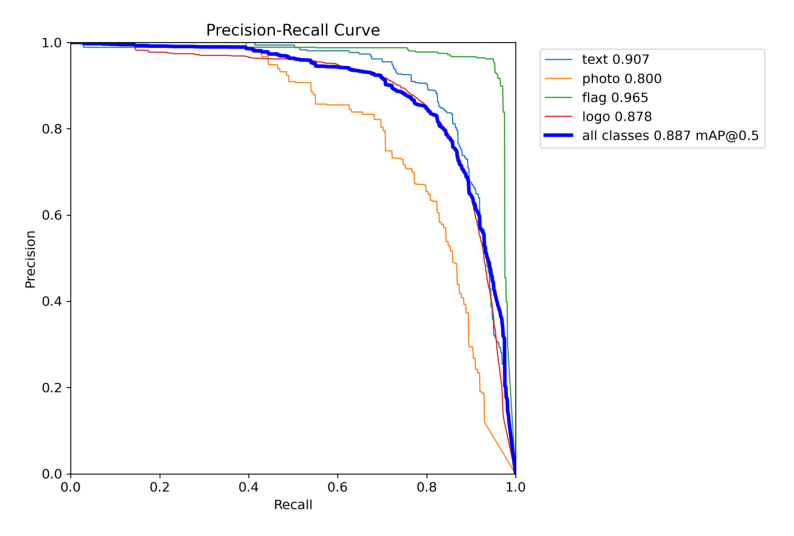

In [28]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to your fitness plot PNG file
file_path = '/kaggle/working/runs/detect/train/PR_curve.png'
# Read and display the image
img = mpimg.imread(file_path)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.show()


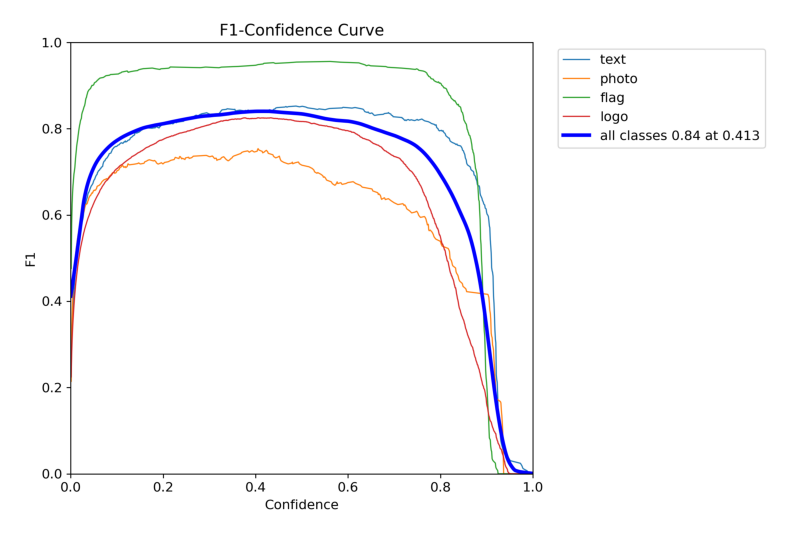

In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to your fitness plot PNG file
file_path = '/kaggle/working/runs/detect/train/F1_curve.png'
# Read and display the image
img = mpimg.imread(file_path)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.show()


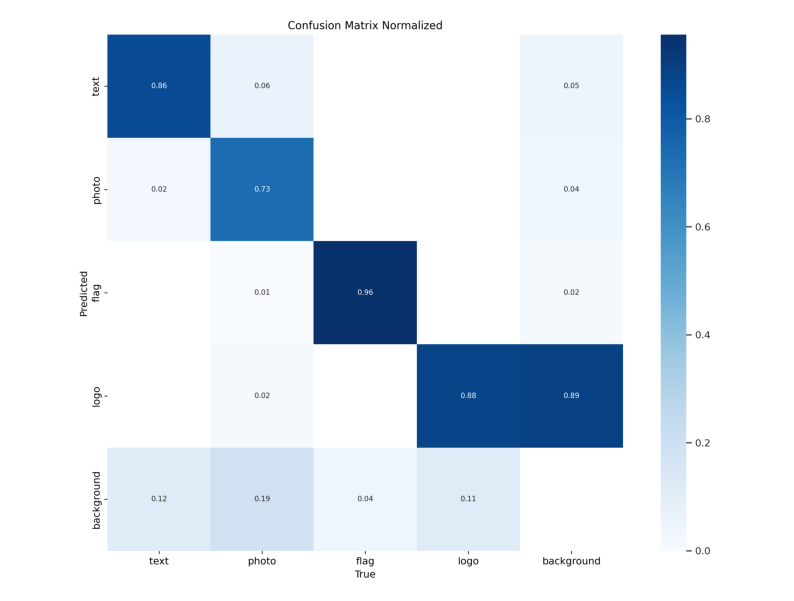

In [30]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to your fitness plot PNG file
file_path = '/kaggle/working/runs/detect/train/confusion_matrix_normalized.png'
# Read and display the image
img = mpimg.imread(file_path)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.show()


Index(['                  epoch', '         train/box_loss',
       '         train/cls_loss', '         train/dfl_loss',
       '   metrics/precision(B)', '      metrics/recall(B)',
       '       metrics/mAP50(B)', '    metrics/mAP50-95(B)',
       '           val/box_loss', '           val/cls_loss',
       '           val/dfl_loss', '                 lr/pg0',
       '                 lr/pg1', '                 lr/pg2'],
      dtype='object')


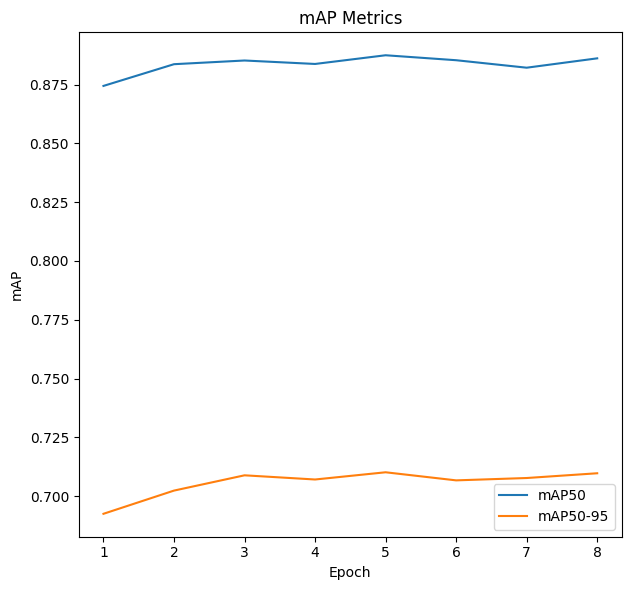

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Read the CSV file
file_path = "/kaggle/working/runs/detect/train/results.csv"
results_df = pd.read_csv(file_path)

# Step 2: Display the columns to understand the available metrics
print(results_df.columns)

# Strip spaces from column names
results_df.columns = results_df.columns.str.strip()

# Step 3: Plot the learning curves
plt.figure(figsize=(12, 6))

# Plot mAP metrics
plt.subplot(1, 2, 2)
plt.plot(results_df['epoch'], results_df['metrics/mAP50(B)'], label='mAP50')
plt.plot(results_df['epoch'], results_df['metrics/mAP50-95(B)'], label='mAP50-95')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('mAP Metrics')
plt.legend()

plt.tight_layout()
plt.show()


## **Learning Curves**

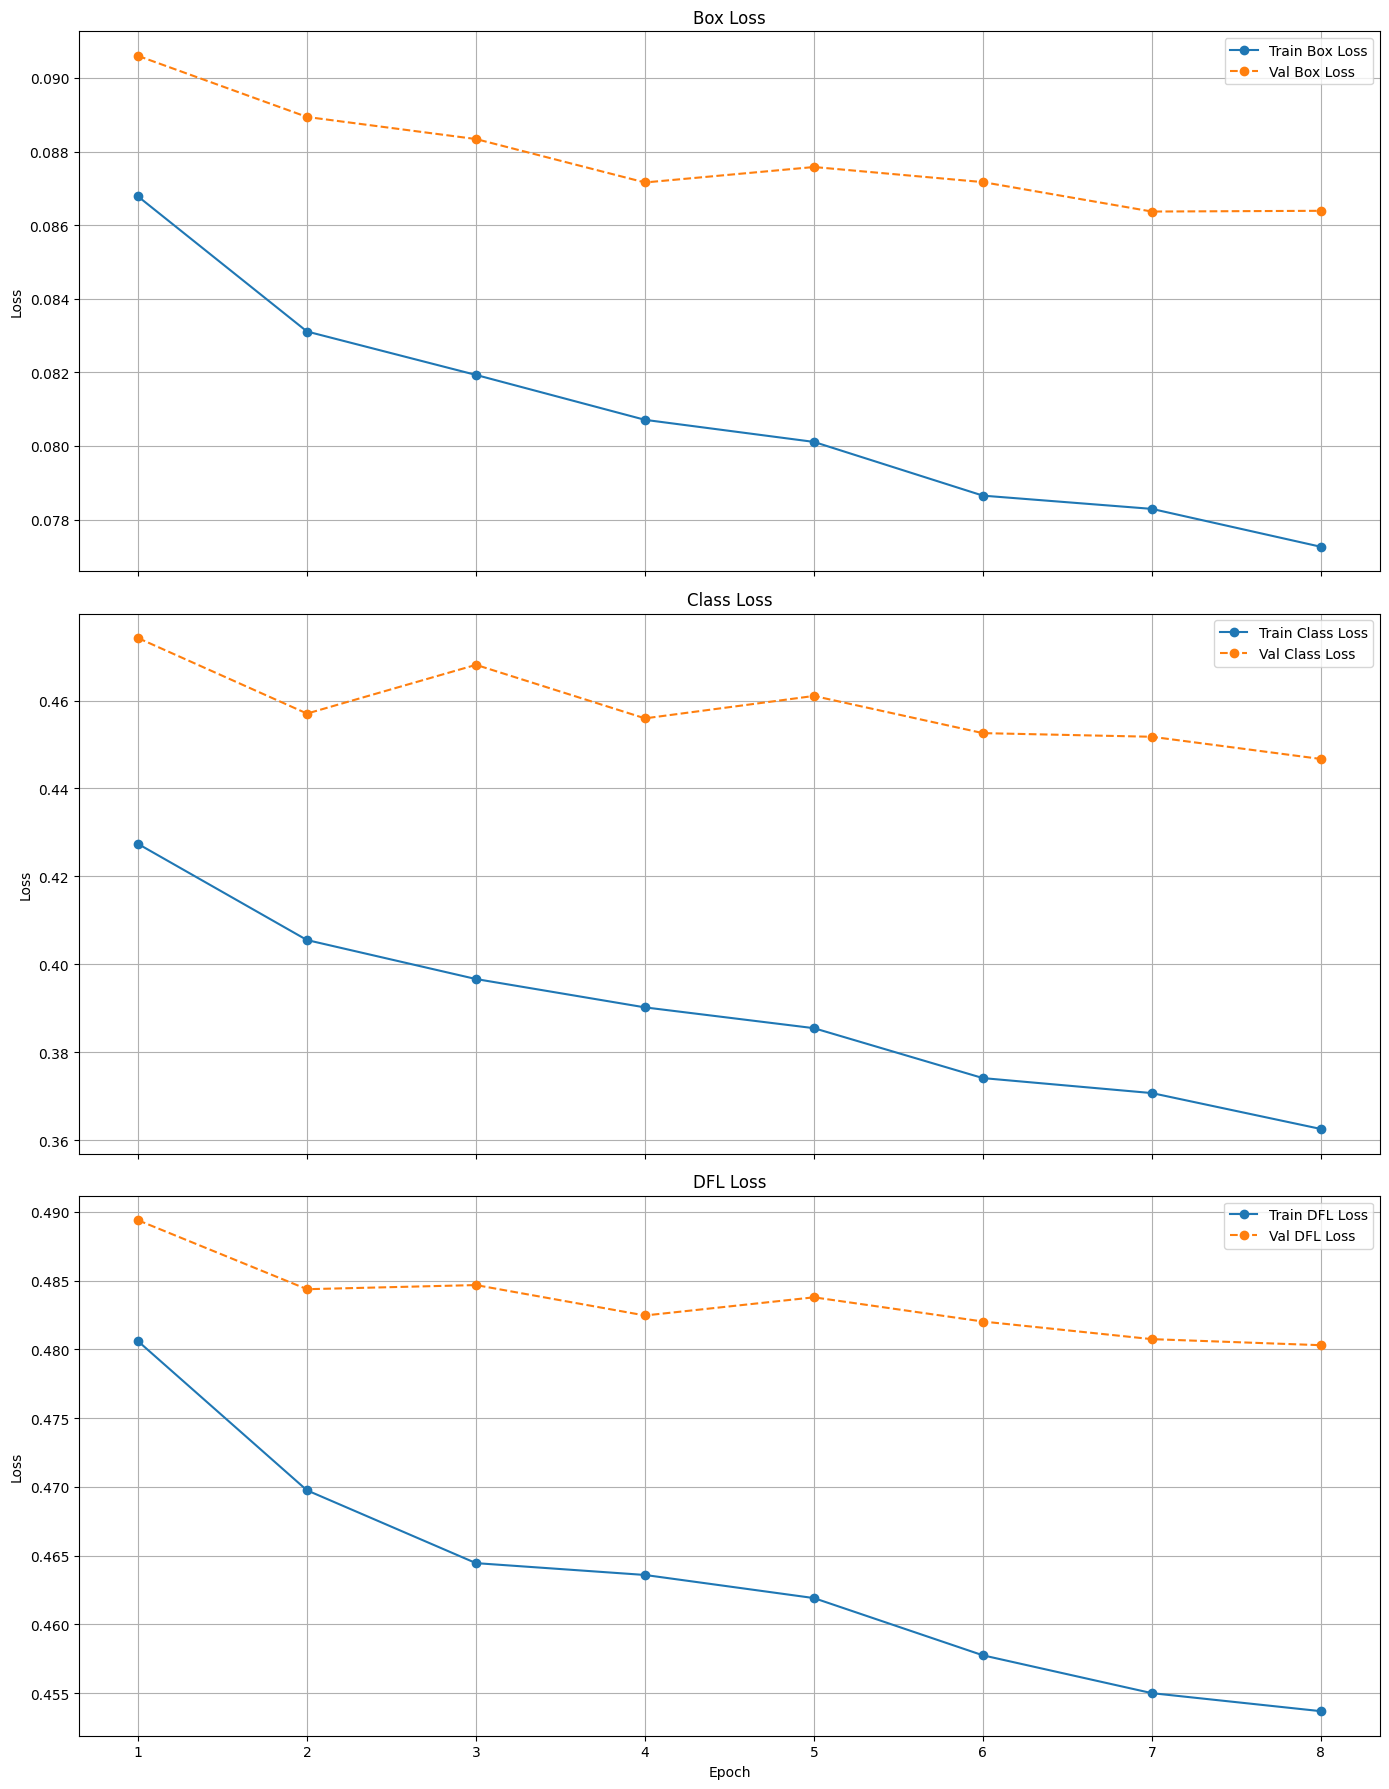

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting learning curves
fig, axs = plt.subplots(3, 1, figsize=(14, 18), sharex=True)

# Box Loss
axs[0].plot(results_df['epoch'], results_df['train/box_loss'], label='Train Box Loss', marker='o')
axs[0].plot(results_df['epoch'], results_df['val/box_loss'], label='Val Box Loss', linestyle='--', marker='o')
axs[0].set_ylabel('Loss')
axs[0].set_title('Box Loss')
axs[0].legend()
axs[0].grid(True)

# Class Loss
axs[1].plot(results_df['epoch'], results_df['train/cls_loss'], label='Train Class Loss', marker='o')
axs[1].plot(results_df['epoch'], results_df['val/cls_loss'], label='Val Class Loss', linestyle='--', marker='o')
axs[1].set_ylabel('Loss')
axs[1].set_title('Class Loss')
axs[1].legend()
axs[1].grid(True)

# DFL Loss
axs[2].plot(results_df['epoch'], results_df['train/dfl_loss'], label='Train DFL Loss', marker='o')
axs[2].plot(results_df['epoch'], results_df['val/dfl_loss'], label='Val DFL Loss', linestyle='--', marker='o')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss')
axs[2].set_title('DFL Loss')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


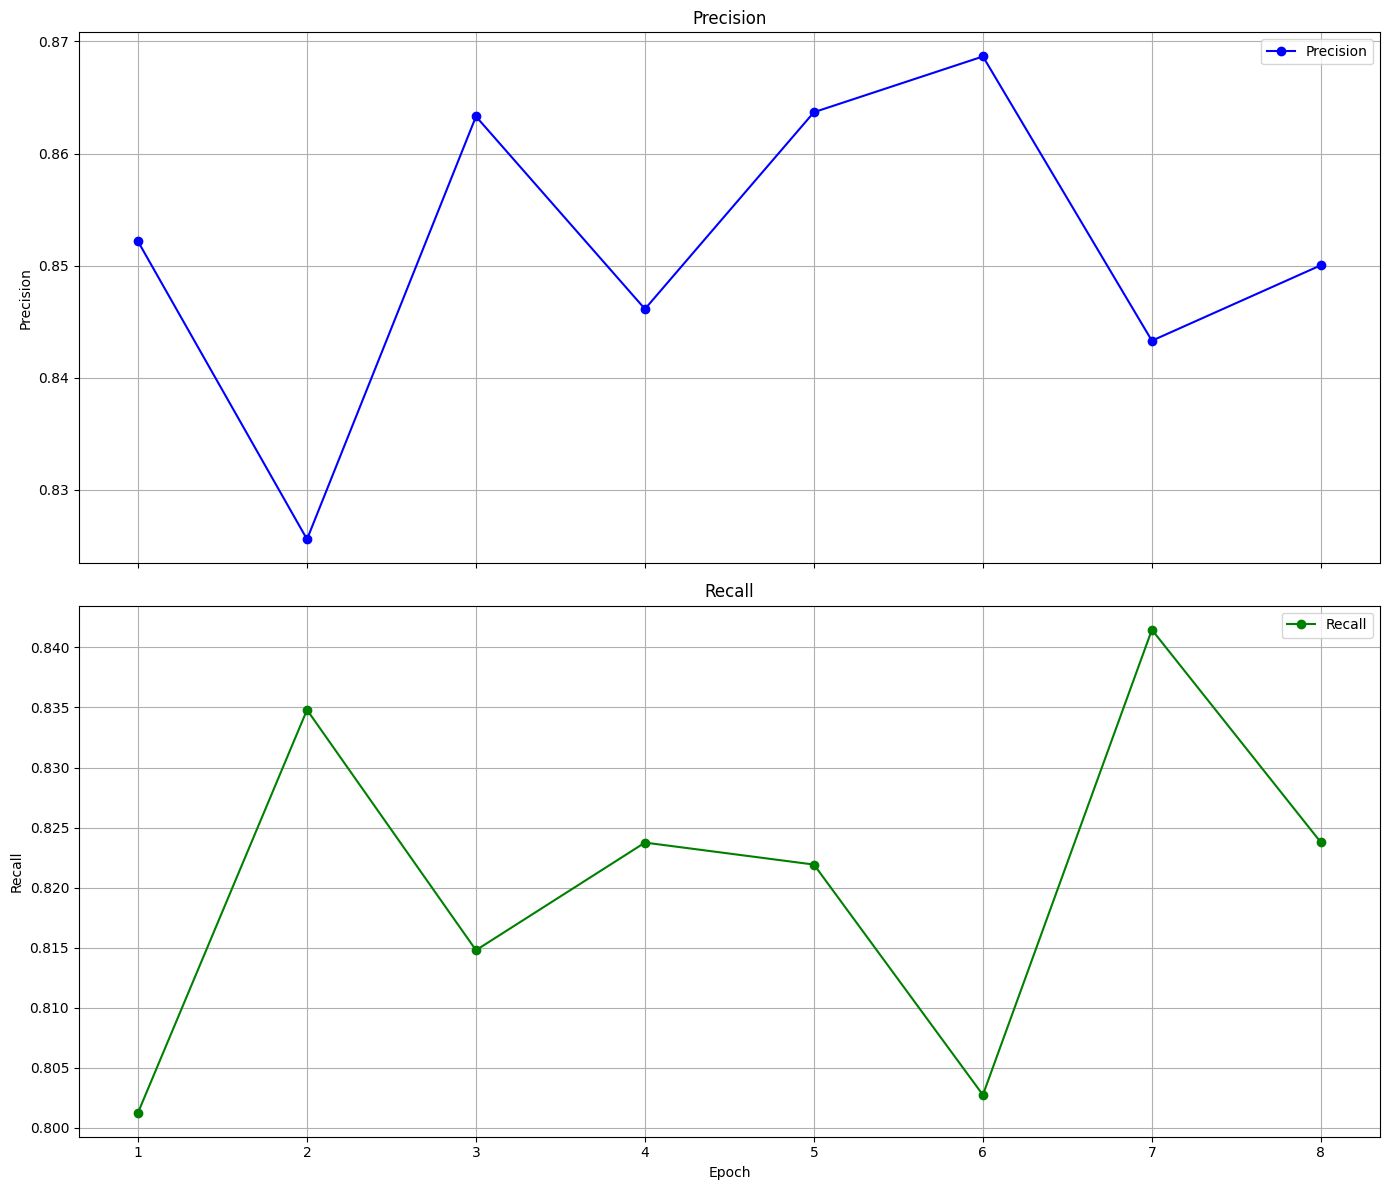

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'results_df' and contains precision and recall columns
# You might need to adjust column names to match your actual DataFrame

# Plotting precision and recall curves
fig, axs = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# Precision
axs[0].plot(results_df['epoch'], results_df['metrics/precision(B)'], label='Precision', marker='o', color='blue')
axs[0].set_ylabel('Precision')
axs[0].set_title('Precision')
axs[0].legend()
axs[0].grid(True)

# Recall
axs[1].plot(results_df['epoch'], results_df['metrics/recall(B)'], label='Recall', marker='o', color='green')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Recall')
axs[1].set_title('Recall')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


# **Prediction**

In [18]:
infer = YOLO('/kaggle/working/runs/detect/train2/weights/best.pt')

In [20]:
results = infer.predict('/kaggle/working/preprocessed_test/images' , save= True , save_txt = True, save_conf=True)


image 1/120 /kaggle/working/preprocessed_test/images/0a9d6a9c-f813-49a3-a253-ae94da3048dd_jpg.rf.6f1a3b5b355d8fdda15afcedc6fca098.jpg: 640x640 12 logos, 8.0ms
image 2/120 /kaggle/working/preprocessed_test/images/0d401782-a740-4017-bb49-576779e84b75_jpg.rf.f10df6aaa19ba06609bc5e634f59f391.jpg: 640x640 10 logos, 7.2ms
image 3/120 /kaggle/working/preprocessed_test/images/114_jpg.rf.74243e572f7b9d0251fea55685756274.jpg: 640x640 1 text, 1 flag, 17 logos, 7.2ms
image 4/120 /kaggle/working/preprocessed_test/images/118_jpg.rf.2a964fc41a02ba26fe35bfd5f55b7fe2.jpg: 640x640 2 texts, 1 flag, 11 logos, 7.3ms
image 5/120 /kaggle/working/preprocessed_test/images/118_jpg.rf.87563b0ea56b30006106dd7d105f9b02.jpg: 640x640 2 texts, 1 flag, 10 logos, 7.3ms
image 6/120 /kaggle/working/preprocessed_test/images/11_jpg.rf.2cc000f02c4479a1d871577502a43333.jpg: 640x640 1 photo, 1 flag, 19 logos, 8.0ms
image 7/120 /kaggle/working/preprocessed_test/images/11_jpg.rf.82eabcef62ae836bcaba5ad91821133c.jpg: 640x640 1 

## **Post Processing**

### **Class-specific Threshold Optimization**

In [21]:
# Extract predictions into a DataFrame
data = []
for result in results:
    for box in result.boxes:
        data.append({
            'class': box.cls.item(),
            'confidence': box.conf.item(),
        })

df = pd.DataFrame(data)

In [37]:
from sklearn.metrics import precision_recall_curve


# Function to calculate optimal thresholds
def optimize_thresholds(df, classes):
    thresholds = {}
    for cls in classes:
        cls_df = df[df['class'] == cls]
        # Here we assume all predictions are positive for precision-recall curve calculation
        y_true = np.ones(len(cls_df))  # Replace this with actual labels if available
        y_scores = cls_df['confidence'].values
        precision, recall, thresholds_cls = precision_recall_curve(y_true, y_scores)
        f1_scores = 2 * (precision * recall) / (precision + recall)
        optimal_threshold = thresholds_cls[np.argmax(f1_scores)]
        thresholds[cls] = optimal_threshold
    return thresholds

# Get unique classes from the DataFrame
classes = df['class'].unique()

# Optimize thresholds
optimal_thresholds = optimize_thresholds(df, classes)

# Print optimal thresholds for each class
for cls, threshold in optimal_thresholds.items():
    print(f'Class {cls}: Optimal Threshold = {threshold}')

Class 3.0: Optimal Threshold = 0.2500472068786621
Class 0.0: Optimal Threshold = 0.286825031042099
Class 2.0: Optimal Threshold = 0.29221200942993164
Class 1.0: Optimal Threshold = 0.26799091696739197


### **Running Predictions again**

In [22]:
# Define the optimal thresholds for each class
optimal_thresholds = {
    3.0: 0.2500472068786621,
    2.0: 0.29221200942993164,
    0.0: 0.286825031042099,
    1.0: 0.26799091696739197
}


# Run inference
results = model.predict('/kaggle/working/preprocessed_test/images', save=True, save_txt=True, save_conf=True)

# Function to filter predictions based on class-specific thresholds
def filter_predictions(results, thresholds):
    filtered_results = []
    for result in results:
        filtered_boxes = []
        for box in result.boxes:
            class_id = box.cls.item()
            confidence = box.conf.item()
            if confidence >= thresholds[class_id]:
                filtered_boxes.append(box)
        result.boxes = filtered_boxes  # Update the result with filtered boxes
        filtered_results.append(result)
    return filtered_results

# Filter the results using the optimal thresholds
filtered_results = filter_predictions(results, optimal_thresholds)



image 1/120 /kaggle/working/preprocessed_test/images/0a9d6a9c-f813-49a3-a253-ae94da3048dd_jpg.rf.6f1a3b5b355d8fdda15afcedc6fca098.jpg: 640x640 12 logos, 8.6ms
image 2/120 /kaggle/working/preprocessed_test/images/0d401782-a740-4017-bb49-576779e84b75_jpg.rf.f10df6aaa19ba06609bc5e634f59f391.jpg: 640x640 10 logos, 7.2ms
image 3/120 /kaggle/working/preprocessed_test/images/114_jpg.rf.74243e572f7b9d0251fea55685756274.jpg: 640x640 1 text, 1 flag, 17 logos, 7.2ms
image 4/120 /kaggle/working/preprocessed_test/images/118_jpg.rf.2a964fc41a02ba26fe35bfd5f55b7fe2.jpg: 640x640 2 texts, 1 flag, 11 logos, 9.5ms
image 5/120 /kaggle/working/preprocessed_test/images/118_jpg.rf.87563b0ea56b30006106dd7d105f9b02.jpg: 640x640 2 texts, 1 flag, 10 logos, 7.4ms
image 6/120 /kaggle/working/preprocessed_test/images/11_jpg.rf.2cc000f02c4479a1d871577502a43333.jpg: 640x640 1 photo, 1 flag, 19 logos, 7.2ms
image 7/120 /kaggle/working/preprocessed_test/images/11_jpg.rf.82eabcef62ae836bcaba5ad91821133c.jpg: 640x640 1 

# **Testing**

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Define the directory containing the images
directory = '/kaggle/working/runs/detect/train23'

# List all files in the directory
all_files = os.listdir(directory)

# Filter out non-image files (optional)
image_files = [file for file in all_files if file.endswith(('jpg', 'jpeg', 'png', 'bmp', 'gif'))]

# Select 5 random image files
random_files = random.sample(image_files, 3)

# Display the images
plt.figure(figsize=(15, 10))
for i, file in enumerate(random_files):
    img_path = os.path.join(directory, file)
    img = Image.open(img_path)
    
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(file)
    plt.axis('off')

plt.show()
